Semana 10 - Transfer Learning

## Exercício 1: Treino from scratch
Treinar do zero o modelo ResNet18 no dataset MNIST

In [11]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Configuração do device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name()}')

Usando device: cuda
GPU: Tesla T4


In [13]:
# Preparação dos dados
root_path = './data'

trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root=root_path, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=root_path, train=False, transform=trans)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, test_loader, epochs, learning_rate, device):
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Treino
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * train_correct / train_total)

        # Validação
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(100 * test_correct / test_total)

        print(f'Época [{epoch+1}/{epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, '
              f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def plot_results(train_losses, test_losses, train_accuracies, test_accuracies, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Treino')
    plt.plot(test_losses, label='Teste')
    plt.title(f'{title} - Evolução da Perda (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Treino')
    plt.plot(test_accuracies, label='Teste')
    plt.title(f'{title} - Evolução da Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Exercício 1: Treino from scratch (do zero)

Época [1/6], Train Loss: 0.1072, Train Acc: 96.76%, Test Loss: 0.0338, Test Acc: 98.85%
Época [2/6], Train Loss: 0.0449, Train Acc: 98.68%, Test Loss: 0.0441, Test Acc: 98.76%
Época [3/6], Train Loss: 0.0376, Train Acc: 98.81%, Test Loss: 0.0342, Test Acc: 99.01%
Época [4/6], Train Loss: 0.0283, Train Acc: 99.14%, Test Loss: 0.0294, Test Acc: 99.04%
Época [5/6], Train Loss: 0.0239, Train Acc: 99.26%, Test Loss: 0.0166, Test Acc: 99.45%
Época [6/6], Train Loss: 0.0206, Train Acc: 99.37%, Test Loss: 0.0222, Test Acc: 99.34%

Acurácia final no conjunto de teste: 99.34%


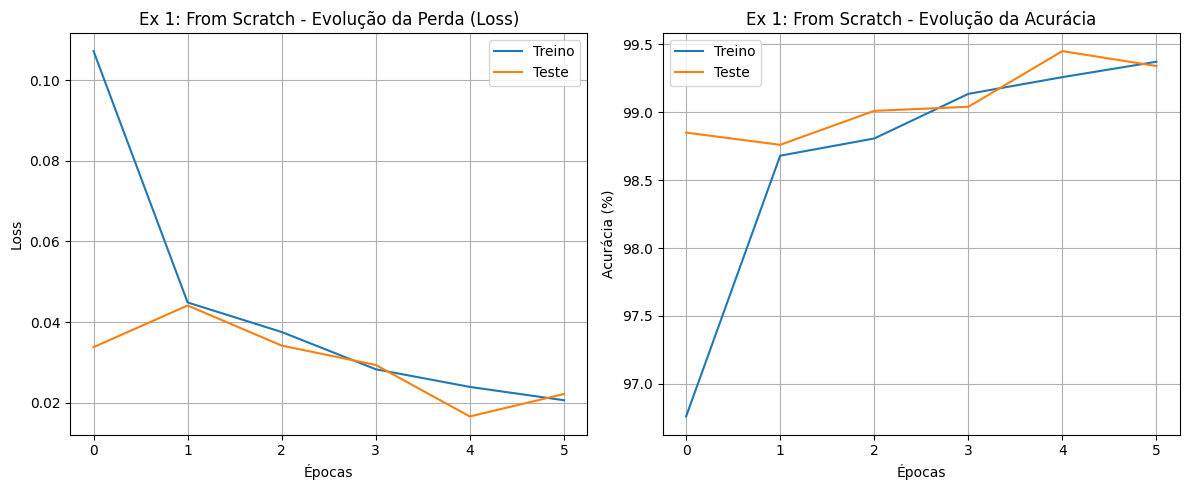

In [15]:
model_ex1 = resnet18(weights=None)
model_ex1.fc = nn.Linear(model_ex1.fc.in_features, 10)

learning_rate = 0.001
epochs = 6

train_losses_ex1, test_losses_ex1, train_accs_ex1, test_accs_ex1 = train_model(
    model_ex1, train_loader, test_loader, epochs, learning_rate, device
)

final_acc_ex1 = evaluate_model(model_ex1, test_loader, device)
print(f'\nAcurácia final no conjunto de teste: {final_acc_ex1:.2f}%')

plot_results(train_losses_ex1, test_losses_ex1, train_accs_ex1, test_accs_ex1, "Ex 1: From Scratch")

## Exercício 2: Utilizar ResNet18 pré-treinado apenas para avaliação (sem treino)

In [16]:
from torchvision.models import ResNet18_Weights

model_ex2 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_ex2.fc = nn.Linear(model_ex2.fc.in_features, 10)
model_ex2 = model_ex2.to(device)

acc_ex2 = evaluate_model(model_ex2, test_loader, device)
print(f'Acurácia sem treino: {acc_ex2:.2f}%')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


Acurácia sem treino: 11.51%


## Exercício 3.1: Fine-tuning - congelando todas as camadas exceto a última (fc)

Época [1/6], Train Loss: 0.3269, Train Acc: 91.46%, Test Loss: 0.1676, Test Acc: 94.88%
Época [2/6], Train Loss: 0.1637, Train Acc: 94.89%, Test Loss: 0.1417, Test Acc: 95.58%
Época [3/6], Train Loss: 0.1422, Train Acc: 95.57%, Test Loss: 0.1129, Test Acc: 96.45%
Época [4/6], Train Loss: 0.1300, Train Acc: 95.87%, Test Loss: 0.1335, Test Acc: 95.84%
Época [5/6], Train Loss: 0.1215, Train Acc: 96.08%, Test Loss: 0.1098, Test Acc: 96.60%
Época [6/6], Train Loss: 0.1174, Train Acc: 96.20%, Test Loss: 0.1153, Test Acc: 96.38%

Acurácia final no conjunto de teste: 96.38%


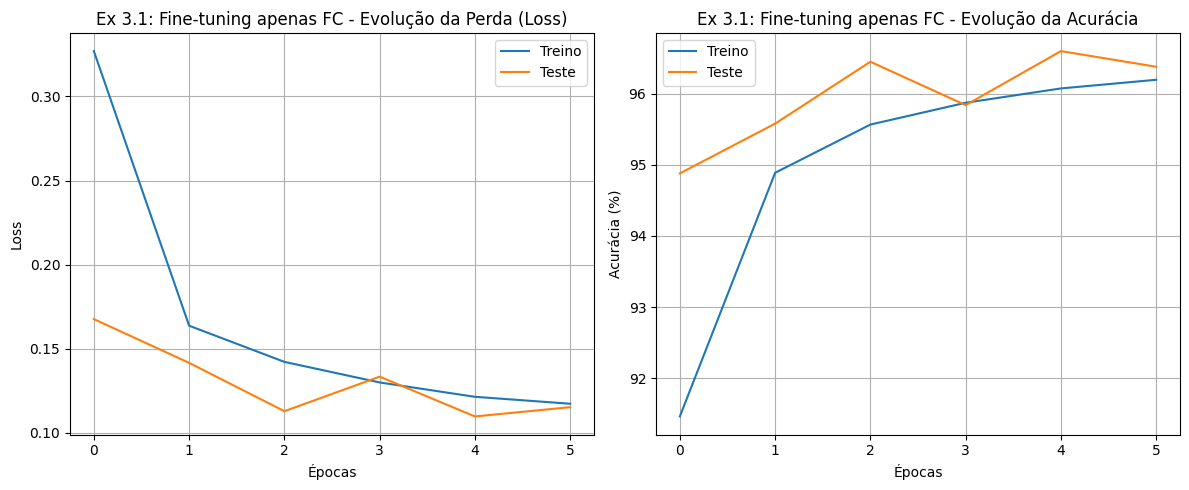

In [17]:
model_ex31 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# congelando todas as camadas
for param in model_ex31.parameters():
    param.requires_grad = False

# desongelar apenas última camada
model_ex31.fc = nn.Linear(model_ex31.fc.in_features, 10)

train_losses_ex31, test_losses_ex31, train_accs_ex31, test_accs_ex31 = train_model(
    model_ex31, train_loader, test_loader, epochs, learning_rate, device
)

final_acc_ex31 = evaluate_model(model_ex31, test_loader, device)
print(f'\nAcurácia final no conjunto de teste: {final_acc_ex31:.2f}%')

plot_results(train_losses_ex31, test_losses_ex31, train_accs_ex31, test_accs_ex31, "Ex 3.1: Fine-tuning apenas FC")

## Exercício 3.2: Fine-tuning parcial - descongelar Layer 4 e última camada

Época [1/6], Train Loss: 0.0679, Train Acc: 97.92%, Test Loss: 0.0362, Test Acc: 98.88%
Época [2/6], Train Loss: 0.0327, Train Acc: 98.97%, Test Loss: 0.0230, Test Acc: 99.25%
Época [3/6], Train Loss: 0.0210, Train Acc: 99.36%, Test Loss: 0.0258, Test Acc: 99.21%
Época [4/6], Train Loss: 0.0163, Train Acc: 99.47%, Test Loss: 0.0290, Test Acc: 99.22%
Época [5/6], Train Loss: 0.0154, Train Acc: 99.52%, Test Loss: 0.0314, Test Acc: 99.26%
Época [6/6], Train Loss: 0.0109, Train Acc: 99.64%, Test Loss: 0.0420, Test Acc: 98.88%

Acurácia final no conjunto de teste: 98.88%


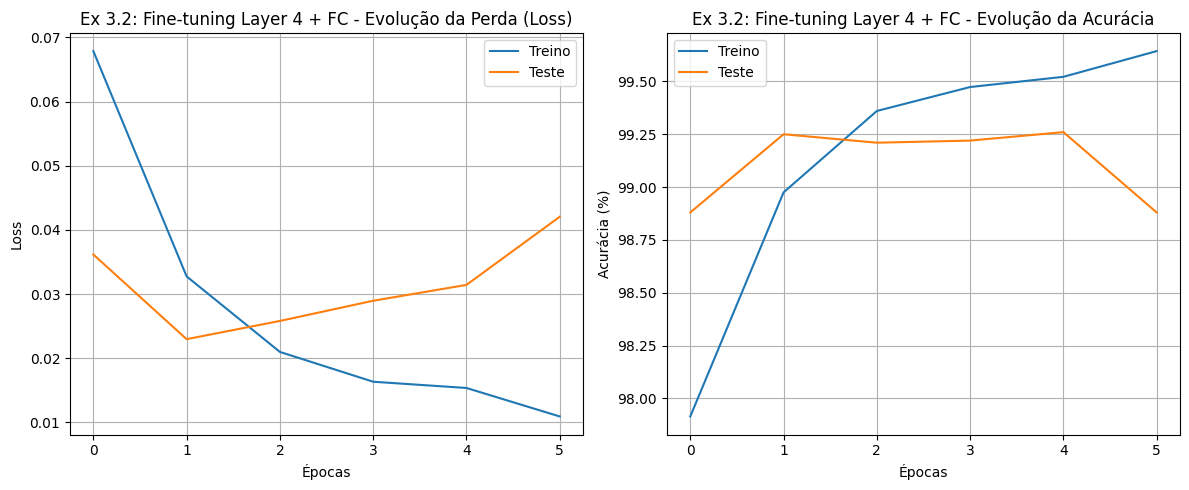

In [18]:
model_ex32 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

for param in model_ex32.parameters():
    param.requires_grad = False

# rdecongelando layer4
for param in model_ex32.layer4.parameters():
    param.requires_grad = True

model_ex32.fc = nn.Linear(model_ex32.fc.in_features, 10)

train_losses_ex32, test_losses_ex32, train_accs_ex32, test_accs_ex32 = train_model(
    model_ex32, train_loader, test_loader, epochs, learning_rate, device
)

final_acc_ex32 = evaluate_model(model_ex32, test_loader, device)
print(f'\nAcurácia final no conjunto de teste: {final_acc_ex32:.2f}%')

plot_results(train_losses_ex32, test_losses_ex32, train_accs_ex32, test_accs_ex32, "Ex 3.2: Fine-tuning Layer 4 + FC")

## Exercício 3.3: Fine-tuning total - descongelar todos os Layers

Época [1/6], Train Loss: 0.0778, Train Acc: 97.65%, Test Loss: 0.0293, Test Acc: 98.94%
Época [2/6], Train Loss: 0.0425, Train Acc: 98.69%, Test Loss: 0.0226, Test Acc: 99.33%
Época [3/6], Train Loss: 0.0328, Train Acc: 99.01%, Test Loss: 0.0525, Test Acc: 98.46%
Época [4/6], Train Loss: 0.0282, Train Acc: 99.12%, Test Loss: 0.0282, Test Acc: 99.07%
Época [5/6], Train Loss: 0.0211, Train Acc: 99.36%, Test Loss: 0.0304, Test Acc: 99.20%
Época [6/6], Train Loss: 0.0188, Train Acc: 99.44%, Test Loss: 0.0194, Test Acc: 99.35%

Acurácia final no conjunto de teste: 99.35%


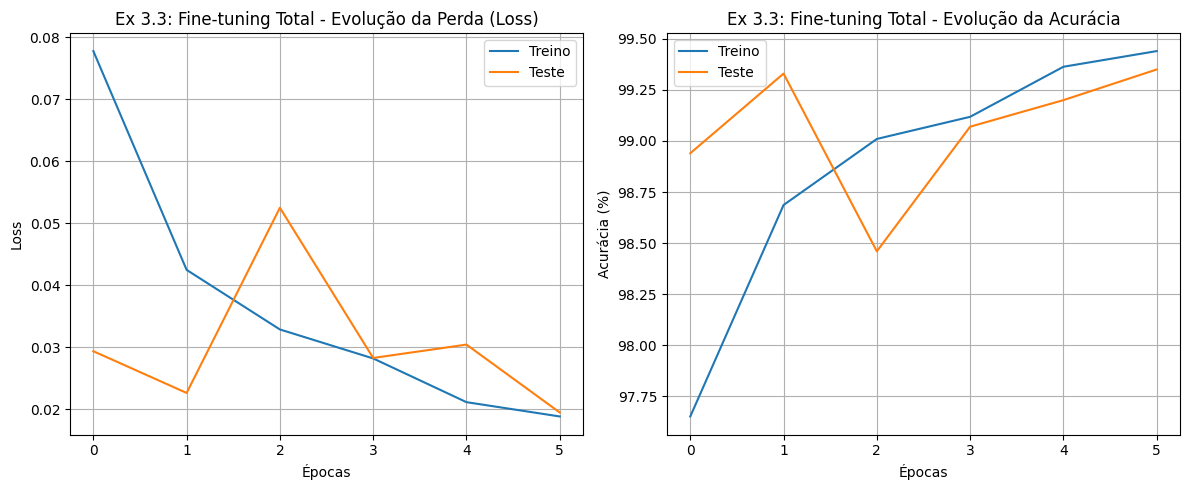

In [19]:
model_ex33 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

for param in model_ex33.parameters():
    param.requires_grad = True

# trocando
model_ex33.fc = nn.Linear(model_ex33.fc.in_features, 10)

train_losses_ex33, test_losses_ex33, train_accs_ex33, test_accs_ex33 = train_model(
    model_ex33, train_loader, test_loader, epochs, learning_rate, device
)

final_acc_ex33 = evaluate_model(model_ex33, test_loader, device)
print(f'\nAcurácia final no conjunto de teste: {final_acc_ex33:.2f}%')

plot_results(train_losses_ex33, test_losses_ex33, train_accs_ex33, test_accs_ex33, "Ex 3.3: Fine-tuning Total")

## Exercício 4: Comparação dos Resultados


Acurácia final no conjunto de teste:

1. Exercício 1 - From Scratch: 99.34%
2. Exercício 2 - Pré-treinado (sem treino): 11.51%
3. Exercício 3.1 - Fine-tuning apenas FC: 96.38%
4. Exercício 3.2 - Fine-tuning Layer 4 + FC: 98.88%
5. Exercício 3.3 - Fine-tuning Total: 99.35%


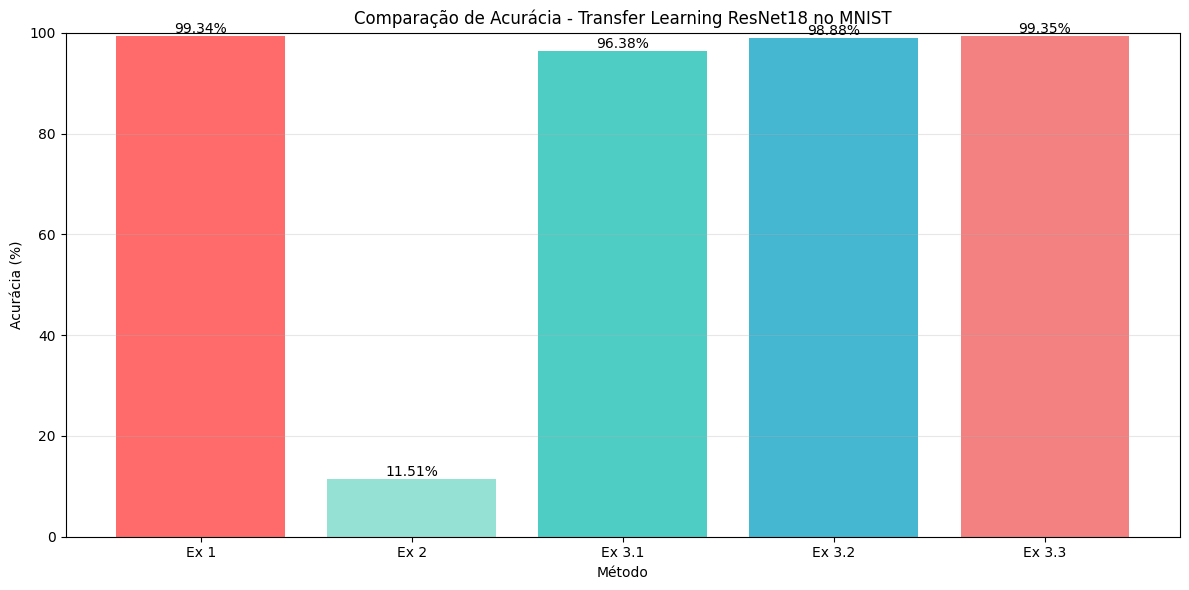

In [20]:
results = {
    'Exercício 1 - From Scratch': final_acc_ex1,
    'Exercício 2 - Pré-treinado (sem treino)': acc_ex2,
    'Exercício 3.1 - Fine-tuning apenas FC': final_acc_ex31,
    'Exercício 3.2 - Fine-tuning Layer 4 + FC': final_acc_ex32,
    'Exercício 3.3 - Fine-tuning Total': final_acc_ex33
}

print("\nAcurácia final no conjunto de teste:\n")
for i, (name, acc) in enumerate(results.items(), 1):
    print(f"{i}. {name}: {acc:.2f}%")

plt.figure(figsize=(12, 6))
names = list(results.keys())
accs = list(results.values())
colors = ['#ff6b6b', '#95e1d3', '#4ecdc4', '#45b7d1', '#f38181']

bars = plt.bar(range(len(names)), accs, color=colors)
plt.xlabel('Método')
plt.ylabel('Acurácia (%)')
plt.title('Comparação de Acurácia - Transfer Learning ResNet18 no MNIST')
plt.xticks(range(len(names)), ['Ex 1', 'Ex 2', 'Ex 3.1', 'Ex 3.2', 'Ex 3.3'])
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()